In [1201]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

#Read the csv files
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

train

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,NaN,S
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C148,C


# Title

First thing we notice is that each passenger seems to have a title in his name. It will be relevant as more priviledged social classes were prioritized. The format it follows is a space before and a period after the title. We will leverage this using a regex to create a new feature.

How many passengers do not have a title ? :  0
How many passengers do not have a title ? :  0


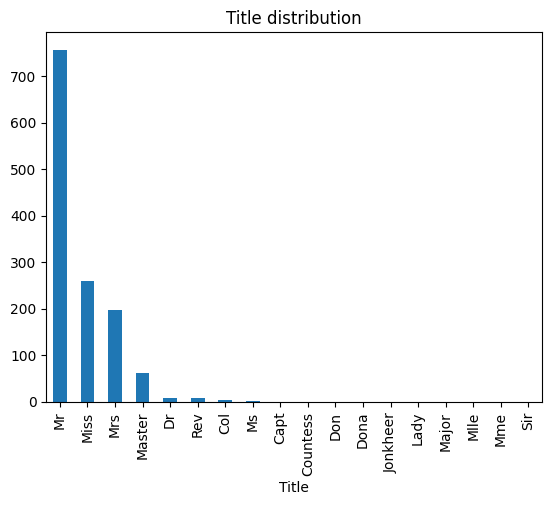

In [1202]:
#Create a new column 'Title' based on the 'Name'
def clean_title(data):
    data['Title'] = data['Name'].str.extract(' ([A-Za-z]+)\.', expand=False)
    print('How many passengers do not have a title ? : ',data['Title'].isna().sum())
    
    return data

train = clean_title(train)
test = clean_title(test)

unique_values = train.groupby('Title')['Title'].count() + test.groupby('Title')['Title'].count()
unique_values.sort_values(ascending=False).plot(kind='bar',x='Title',y='Count',title='Title distribution')
plt.show()

In [1203]:
#Let's map the titles to a numerical value, all the non-relevant titles will be grouped as 4

title_mapping = {
    'Mr': 0,
    'Mrs': 1,
    'Miss': 2,
    'Master': 3
}

def map_title(data,title_mapping):
    data['Title'] = data['Title'].map(title_mapping).fillna(4).astype('category')
    return data

train = map_title(train,title_mapping)
test = map_title(test,title_mapping)


# Sex

Let's leverage the sex as it is famously known that women were priotized over men.

In [1204]:
#Numerize the 'Sex' column
def replace_sex(data):   
    data['Sex'] = data['Sex'].replace({'male': 0, 'female': 1}).astype('category')
    return data

train = replace_sex(train)
test = replace_sex(test)


# Fare
The amount of money spent on the ticket is important as it adds to the economic status of the passenger, which will definitely influence his survival rate.

How many missing values in the 'Fare' train column ? :  0
How many missing values in the 'Fare' test column ? :  1


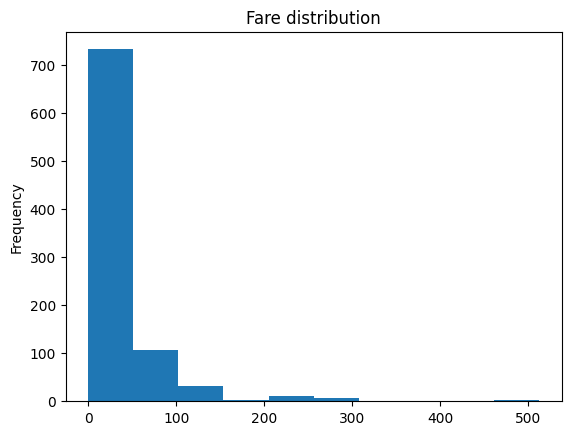

count    891.000000
mean      32.204208
std       49.693429
min        0.000000
25%        7.910400
50%       14.454200
75%       31.000000
max      512.329200
Name: Fare, dtype: float64


In [1205]:
print("How many missing values in the 'Fare' train column ? : ",train['Fare'].isna().sum())
print("How many missing values in the 'Fare' test column ? : ",test['Fare'].isna().sum())

#Plot the 'Fare' column
train['Fare'].plot(kind='hist',title='Fare distribution')
plt.show()

print(train['Fare'].describe())


In [1206]:
#Filling the empty Fare values based on the median value as there's only 1 missing value in the test set
combined = pd.concat([train, test], ignore_index=True)

def fill_fare(data,combined):
    data['Fare'] = data['Fare'].fillna(combined.groupby(['Title','Pclass'])['Fare'].transform('median')).astype(int) 
    data['Fare'] = pd.qcut(data['Fare'],3).cat.codes
    return data

train = fill_fare(train,combined)
test = fill_fare(test,combined)

C:\Users\noahg\AppData\Local\Temp\ipykernel_16560\1671495249.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  data['Fare'] = data['Fare'].fillna(combined.groupby(['Title','Pclass'])['Fare'].transform('median')).astype(int)
C:\Users\noahg\AppData\Local\Temp\ipykernel_16560\1671495249.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  data['Fare'] = data['Fare'].fillna(combined.groupby(['Title','Pclass'])['Fare'].transform('median')).astype(int)


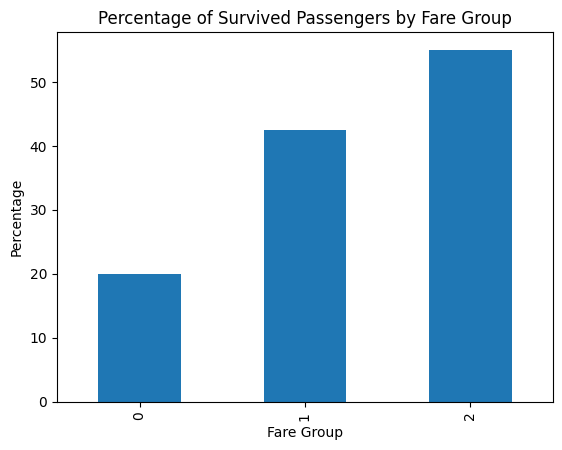

In [1207]:
# Group by Fare groups and calculate the count of survived passengers
survived_counts = train[train['Survived'] == 1].groupby('Fare')['Fare'].count()
# Group by Fare groups and calculate the total number of passengers
total_counts = train.groupby('Fare')['Fare'].count()
# Calculate the percentage of survived passengers for each age group
survived_percentage = (survived_counts / total_counts) * 100

# Plot the results
survived_percentage.plot(kind='bar', title='Percentage of Survived Passengers by Fare Group')
plt.xlabel('Fare Group')
plt.ylabel('Percentage')
plt.show()


# Age

Once again age is an important feature as children were given priority over adults.

In [1208]:
print("How many missing values in the 'Age' column ? in the train set: ",train['Age'].isna().sum())
print("How many missing values in the 'Age' column ? in the test set: ",test['Age'].isna().sum())

#Several passengers are missing the 'Age' value, let's try a way to fill them.
#Filling the empty Age values based on the median value of its combination of Title & Fare categories

combined = pd.concat([train, test], ignore_index=True)

def fill_age(data,combined):
    data['Age'] = data['Age'].fillna(combined.groupby(['Title','Pclass'])['Age'].transform('median')).astype(int) 
    data['Age'] = pd.qcut(data['Age'],4).cat.codes
    return data

train = fill_age(train,combined)
test = fill_age(test,combined)

How many missing values in the 'Age' column ? in the train set:  177
How many missing values in the 'Age' column ? in the test set:  86


C:\Users\noahg\AppData\Local\Temp\ipykernel_16560\3742197637.py:10: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  data['Age'] = data['Age'].fillna(combined.groupby(['Title','Pclass'])['Age'].transform('median')).astype(int)
C:\Users\noahg\AppData\Local\Temp\ipykernel_16560\3742197637.py:10: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  data['Age'] = data['Age'].fillna(combined.groupby(['Title','Pclass'])['Age'].transform('median')).astype(int)


<Axes: title={'center': 'Percentage of Survived Passengers by Age Group and Passenger Class'}, xlabel='Pclass'>

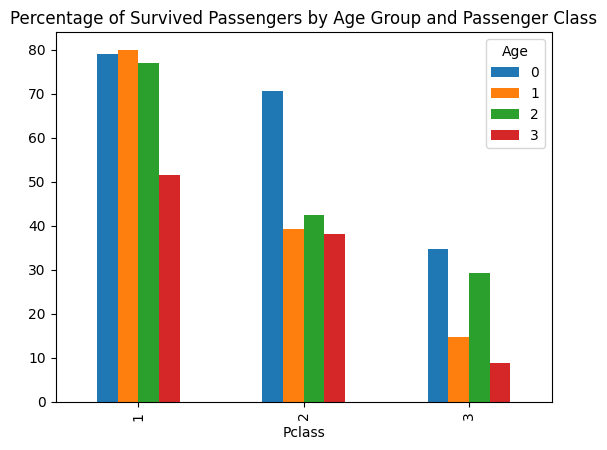

In [1209]:
# Group by Age Group and Passenger Class and calculate the count of survived passengers
survived_counts = train[train['Survived'] == 1].groupby(['Pclass','Age'])['Age'].count()
# Group by Age Group and Passenger Class and calculate the total number of passengers
total_counts = train.groupby(['Pclass','Age'])['Age'].count()
# Calculate the percentage of survived passengers for each age group
survived_percentage = (survived_counts / total_counts) * 100
# Plot the results
survived_percentage.unstack().plot(kind='bar', title='Percentage of Survived Passengers by Age Group and Passenger Class')

# Family

Family is everything, let's group passengers by family name.

In [1210]:
#Fusing SibSp and Parch into Fam, 0 if alone and 1 if with family

def fam_features(data):

    data['has_fam'] = (data['SibSp'] + data['Parch']).apply(lambda x: 1 if x > 0 else 0)
    data['FamSize'] = data['SibSp'] + data['Parch'] + 1

    return data

train = fam_features(train)
test = fam_features(test)


# Group by LastName and FamSize for families with more than 1 member
def fam_survival(data):
    # Initialize 'GrpSurvival' to 0.5 (no info initially)
    data['GrpSurvival'] = 0.5

    for _, grp_df in data[data['FamSize'] > 1].groupby(['LastName', 'FamSize']):
        survival_count = grp_df['Survived'].value_counts()  # Get counts of 0s and 1s
        if survival_count.get(1, 0) >= survival_count.get(0, 0):  # Majority or tie survived
            data.loc[grp_df.index, 'GrpSurvival'] = 1
        else:  # Majority perished
            data.loc[grp_df.index, 'GrpSurvival'] = 0

    return data

combined = pd.concat([train, test], ignore_index=True)
combined.set_index(['PassengerId'], inplace=True) ## This is to make sure of a unique index for both train & test

combined['LastName'] = combined['Name'].apply(lambda x: str.split(x, ",")[0])
combined = fam_survival(combined)

print("Number of passengers with family survival information:", 
      combined.loc[combined['GrpSurvival']!=0.5].shape[0])



Number of passengers with family survival information: 519


# Friends 

Groups with the same ticket but not from the same family

In [1212]:
def ticket_survival(data):
    for _, grp_df in data.groupby(['Ticket']):
        if len(grp_df) > 1:
            survival_count = grp_df['Survived'].value_counts()
            for ind, row in grp_df.iterrows():
                if row['GrpSurvival'] == 0.5:  # For a person with no family info
                    if survival_count.get(1, 0) >= survival_count.get(0, 0):  # If majority or tie survived
                        data.loc[grp_df.index, 'GrpSurvival'] = 1
                    else:  # If all family members perished
                        data.loc[grp_df.index, 'GrpSurvival'] = 0
    return data

combined = ticket_survival(combined)

# Split back into train and test
train = combined.iloc[:len(train)].reset_index()  
test = combined.iloc[len(train):].reset_index()

print("Number of passengers with family survival information:", 
      combined.loc[combined['GrpSurvival']!=0.5].shape[0])

Number of passengers with family survival information: 646


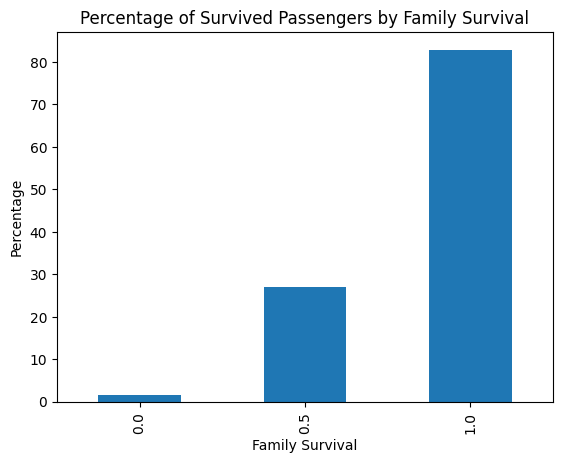

In [ ]:
#Plot the 'FamSurvival' column with survived passengers

# Split back into train and test
train = combined.iloc[:len(train)].reset_index()  
test = combined.iloc[len(train):].reset_index()

survived_counts = train[train['Survived'] == 1].groupby('GrpSurvival')['GrpSurvival'].count()
total_counts = train.groupby('GrpSurvival')['GrpSurvival'].count()
survived_percentage = (survived_counts / total_counts) * 100

# Plot the results
survived_percentage.plot(kind='bar', title='Percentage of Survived Passengers by Group Survival')
plt.xlabel('Family Survival')
plt.ylabel('Percentage')
plt.show()



In [1214]:
train.drop(['Name','Ticket','Cabin','Embarked','PassengerId','SibSp','Parch','LastName','FamSize','Title'],axis=1,inplace=True)
test.drop(['Name','Ticket','Cabin','Embarked','SibSp','Parch','LastName','Survived','FamSize','Title'],axis=1,inplace=True)

#Split the data into x and y
x_train = train.drop('Survived', axis=1)
y_train = train['Survived']

train.corr()

,Survived,Pclass,Sex,Age,Fare,has_fam,GrpSurvival
Survived,1.000000,-0.338481,0.543351,-0.010876,0.292607,0.203367,0.604711
Pclass,-0.338481,1.000000,-0.131900,-0.433758,-0.687110,-0.135207,-0.375916
Sex,0.543351,-0.131900,1.000000,-0.086842,0.244436,0.303646,0.274786
Age,-0.010876,-0.433758,-0.086842,1.000000,0.200713,-0.104911,0.064330
Fare,0.292607,-0.687110,0.244436,0.200713,1.000000,0.503133,0.243051
has_fam,0.203367,-0.135207,0.303646,-0.104911,0.503133,1.000000,0.141182
GrpSurvival,0.604711,-0.375916,0.274786,0.064330,0.243051,0.141182,1.000000


In [1215]:
from xgboost import XGBClassifier

model = XGBClassifier(enable_categorical=True)
model.fit(x_train, y_train)

pred = model.predict(test.drop('PassengerId', axis=1))
threshold = 0.5

predicted_classes = (pred >= threshold).astype(int)

submission = pd.DataFrame({'PassengerId': test['PassengerId'], 'Survived': predicted_classes.reshape(-1)})
submission.to_csv('submission1.csv', index=False)

<Axes: title={'center': 'Feature Importance (Gain)'}, xlabel='F score', ylabel='Features'>

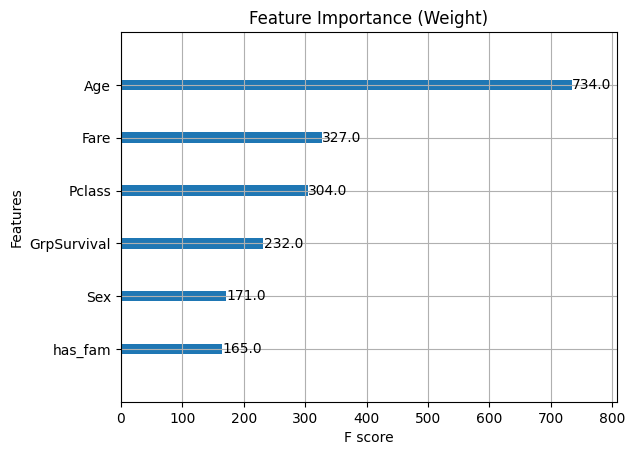

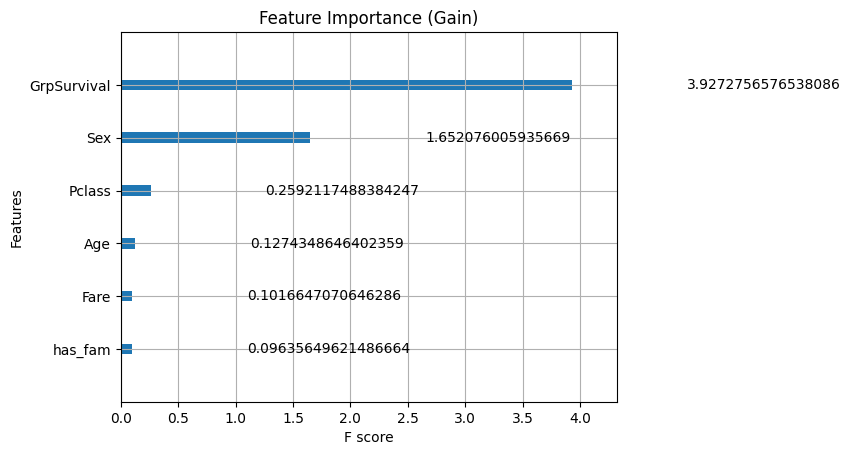

In [1216]:
from xgboost import plot_importance

# Plot using different importance types
plot_importance(model, importance_type='weight', title='Feature Importance (Weight)')
plot_importance(model, importance_type='gain', title='Feature Importance (Gain)')